## Загрузка библиотек

In [1]:
import os

import random
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib
import plotly
import PIL
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

## Загрузка датасета

Также посмотрим количество изображений в датасете и часть из них визуализируем





In [2]:
!git clone 'https://github.com/MelnikDM/Construction.git'

Cloning into 'Construction'...
remote: Enumerating objects: 19537, done.
remote: Counting objects: 100% (5977/5977), done.
remote: Compressing objects: 100% (3125/3125), done.
remote: Total 19537 (delta 2853), reused 5972 (delta 2848), pack-reused 13560
Receiving objects: 100% (19537/19537), 1.10 GiB | 22.80 MiB/s, done.
Resolving deltas: 100% (9780/9780), done.
Updating files: 100% (4571/4571), done.


In [3]:
images_path = '/content/Construction/HardHat_2/data/Images'

In [4]:
images_count = np.array(os.listdir('/content/Construction/HardHat_2/data/Images'))
print(f'Количество изображений в датасете: {images_count.shape[0]}')

Количество изображений в датасете: 2168


In [5]:
def display_multiple_img(images: np.ndarray, images_path: str, cols: int = 2):

    """ Функция для визуализации фотографий """

    assert (images.shape[0] % cols) == 0

    for imagename_pair in images.reshape(-1, cols):
        _, axs = plt.subplots(nrows = 1, ncols = cols, figsize = (10, 10))

        for ind, imagename in enumerate(imagename_pair):
            image = cv2.imread(
                os.path.join(images_path, imagename)
            )
            axs[ind].imshow(image[:,:,::-1])
            axs[ind].axis('off')

In [6]:
images_indices = np.arange(images_count.shape[0], dtype='int')
np.random.shuffle(images_indices)

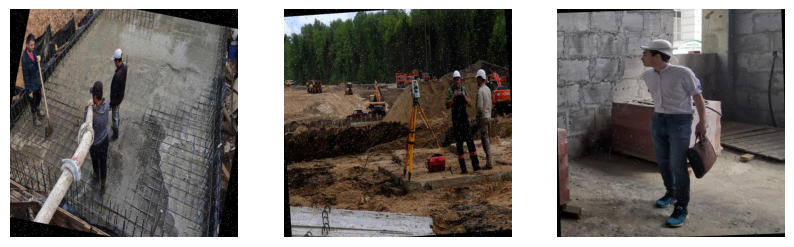

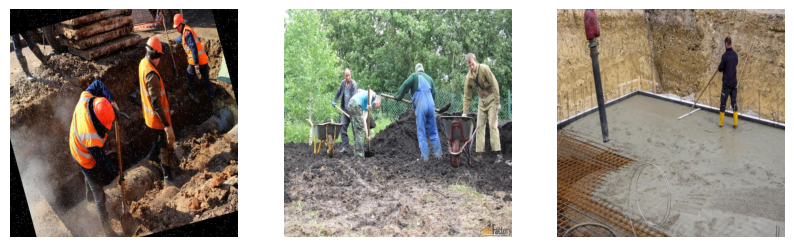

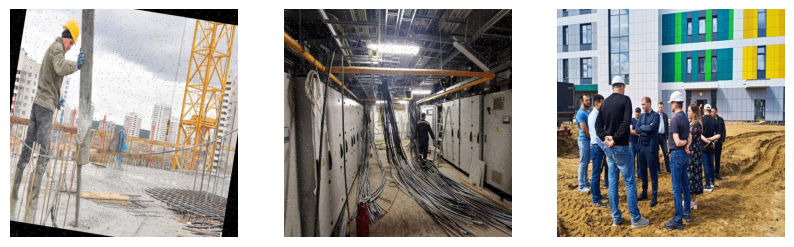

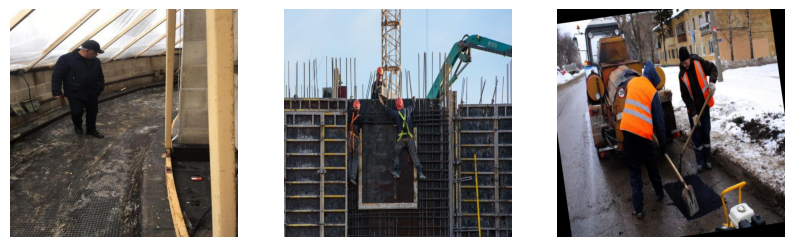

In [7]:
k = 12
first_k_images = images_count[images_indices][:k]

display_multiple_img(
    images=first_k_images,
    images_path=images_path,
    cols=3
)

In [8]:
# Размеры изображений изменены на 640х640 => aspect ratio будет равен 1.

# def get_images_metainfo(images_list: np.ndarray, images_path: str):

#     """
#        Данная функция собирает метаданные изображения
#        Результат функции это список словарей: imagename,
#        width, height, aspect_ratio
#     """

#     metainfo = []

#     for imagename in tqdm(images_list, total = images_list.shape[0]):
#         current_meta = {
#             'imagename': imagename,
#         }

#         image_path = os.path.join(images_path, imagename)
#         width, height, channels = cv2.imread(image_path).shape

#         current_meta['width'] = width
#         current_meta['height'] = height
#         current_meta['aspect_ratio'] = width/height
#         metainfo.append(current_meta)

#     return metainfo

Теперь попробуем построить heatmap с нашими баундинг боксами. Для начала "раздраконим" наш xml и сделаем из него датафрейм pandas

In [9]:
input_folder = r"/content/Construction/HardHat_2/data/Annotations"

# cols = ['name', 'xmin', 'ymin', 'xmax', 'ymax']

def merge_files(input_folder):
    global df2
    xml_list = []
    for file in os.listdir(input_folder):
        df = pd.read_xml(f"{input_folder}/{file}", iterparse={"object": ["name", "xmin", "ymin", "xmax", "ymax"]})
        xml_list.append(df)

    pd.set_option('display.max_columns', None)
    xml_merged = pd.concat(xml_list, ignore_index=True)
    df2 = pd.DataFrame(xml_merged)
    return df2


merge_files(input_folder)

,name,xmin,xmax,ymin,ymax
0,NoHelmet,278,293,199,210
1,NoJacket,275,302,211,238
2,Helmet,304,330,1,24
3,Helmet,386,407,282,315
4,Helmet,306,339,459,487
...,...,...,...,...,...
14765,Helmet,491,510,462,490
14766,Helmet,542,560,274,296
14767,NoJacket,281,325,411,477
14768,NoJacket,105,157,432,525


Попутно взглянем, как распределились наши классы

In [10]:
df2.name.value_counts()

Helmet      5509
Jacket      4105
NoJacket    2760
NoHelmet    2396
Name: name, dtype: int64

In [11]:
fig = px.bar(df2.name.value_counts().sort_index(),
             color=df2.name.value_counts().sort_index().index, opacity=0.85,
             log_y=True,
             labels={"y":"Количество аннотаций на класс", "x":""},
             title="<b>Количество аннотаций на класс</b>",)
fig.update_layout(legend_title=None,
                  xaxis_title="",
                  yaxis_title="<b>Количество аннотаций на класс</b>")

fig.show()

In [12]:
def create_fractional_bbox_coordinates(row):
    """ Данная функция вычисляет долю площади ограничивающего прямоугольника """
    img_width = 640
    img_height = 640
    frac_x_min = row["xmin"]/img_width
    frac_x_max = row["xmax"]/img_width
    frac_y_min = row["ymin"]/img_height
    frac_y_max = row["ymax"]/img_height
    return frac_x_min, frac_x_max, frac_y_min, frac_y_max

In [13]:
df2["frac_x_min"], df2["frac_x_max"], df2["frac_y_min"], df2["frac_y_max"] = \
    zip(*df2.apply(create_fractional_bbox_coordinates, axis=1))

In [14]:
df2

,name,xmin,xmax,ymin,ymax,frac_x_min,frac_x_max,frac_y_min,frac_y_max
0,NoHelmet,278,293,199,210,0.434375,0.457813,0.310937,0.328125
1,NoJacket,275,302,211,238,0.429688,0.471875,0.329688,0.371875
2,Helmet,304,330,1,24,0.475000,0.515625,0.001563,0.037500
3,Helmet,386,407,282,315,0.603125,0.635938,0.440625,0.492188
4,Helmet,306,339,459,487,0.478125,0.529687,0.717187,0.760938
...,...,...,...,...,...,...,...,...,...
14765,Helmet,491,510,462,490,0.767188,0.796875,0.721875,0.765625
14766,Helmet,542,560,274,296,0.846875,0.875000,0.428125,0.462500
14767,NoJacket,281,325,411,477,0.439063,0.507812,0.642188,0.745313
14768,NoJacket,105,157,432,525,0.164062,0.245312,0.675000,0.820312


Создадим столбец **classes**, в который закодируем в виде номера метку. А затем сгенерируем словарь **class_id**, который позволит нам перевести числовые метки обратно в их соответствующие строковые представления.

In [15]:
classes = {'Helmet':0,'NoHelmet':1, 'NoJacket':2, 'Jacket':3}

df2['classes'] = df2['name'].map(classes)

In [16]:
class_id = {i:df2[df2["classes"]==i].iloc[0]["name"] for i in range(4)}

100%|██████████| 14770/14770 [00:00<00:00, 42203.58it/s]


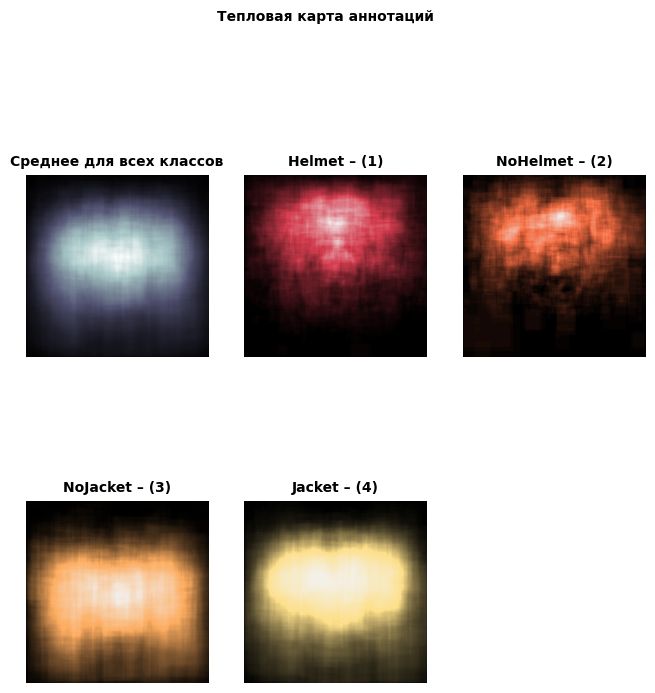

In [17]:
HEATMAP_SIZE = (640, 640, 4)

heatmap = np.zeros((HEATMAP_SIZE), dtype=np.int16)
bbox_np = df2[["classes", "frac_x_min", "frac_x_max", "frac_y_min", "frac_y_max"]].to_numpy()
bbox_np[:, 1:3] *= 640
bbox_np[:, 3:5] *= 640
bbox_np = np.floor(bbox_np).astype(np.int16)

custom_cmaps = [
    matplotlib.colors.LinearSegmentedColormap.from_list(
        colors=[(0.,0.,0.), c, (0.95,0.95,0.95)],
        name=f"custom_{i}") for i,c in enumerate(sns.color_palette("Spectral", 9))
]
custom_cmaps.pop(8)

for row in tqdm(bbox_np, total=bbox_np.shape[0]):
    heatmap[row[3]:row[4]+1, row[1]:row[2]+1, row[0]] += 1

fig = plt.figure(figsize=(8,12))
plt.suptitle("Тепловая карта аннотаций", fontweight="bold", fontsize=10)
for i in range(5):
    plt.subplot(3, 3, i+1)
    if i==0:
        plt.imshow(heatmap.mean(axis=-1), cmap="bone")
        plt.title(f"Среднее для всех классов", fontweight="bold", fontsize=10)
    else:
        plt.imshow(heatmap[:, :, i-1], cmap=custom_cmaps[i-1])
        plt.title(f"{class_id[i-1]} – ({i})", fontweight="bold", fontsize=10)

    plt.axis(False)
plt.show()

В общем, можно было и не строить тепловую карту, так как для данной задачи она совершенно неинформативна.